<a href="https://colab.research.google.com/github/james-mugabo/reddit-narrative-forensics/blob/main/Reddit_CyberForensics_Sentiment_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# --- PHASE 1: PREPARE DATA ---
# This mimics the 'df' we tried to scrape earlier
raw_data = [
    {"title": "Breakthrough in renewable energy research shows 40% efficiency gain", "subreddit": "science", "score": 4500},
    {"title": "I am so incredibly frustrated with the state of local public transit", "subreddit": "news", "score": 1200},
    {"title": "Look at this adorable puppy I found in the park today!", "subreddit": "aww", "score": 8900},
    {"title": "The new update is a complete disaster and full of bugs", "subreddit": "gaming", "score": -150},
    {"title": "I had a wonderful experience at the community garden this morning", "subreddit": "local", "score": 300},
    {"title": "Warning: High levels of toxicity detected in latest water report", "subreddit": "news", "score": 2100}
]
df = pd.DataFrame(raw_data)

# --- PHASE 2: SENTIMENT ANALYSIS ---
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

# Apply the analysis
df['sentiment_score'] = df['title'].apply(analyze_sentiment)

# Categorize the results
df['label'] = df['sentiment_score'].apply(
    lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral')
)

print("Sentiment Analysis Complete!")
df[['title', 'sentiment_score', 'label']]

Sentiment Analysis Complete!


,title,sentiment_score,label
0,Breakthrough in renewable energy research show...,0.7906,Positive
1,I am so incredibly frustrated with the state o...,-0.6087,Negative
2,Look at this adorable puppy I found in the par...,0.6177,Positive
3,The new update is a complete disaster and full...,-0.6249,Negative
4,I had a wonderful experience at the community ...,0.5719,Positive
5,Warning: High levels of toxicity detected in l...,-0.3400,Negative


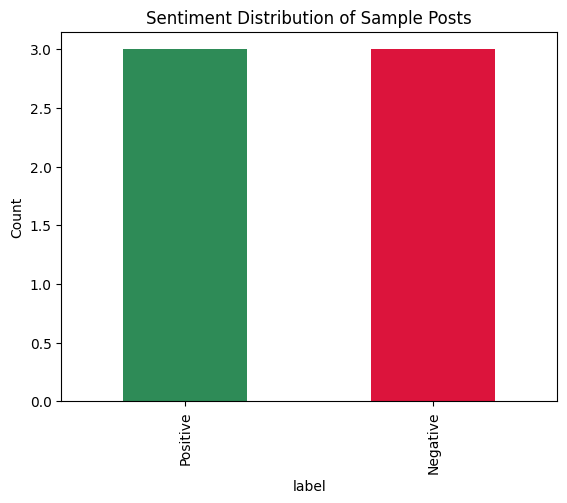

In [2]:
# Create a bar chart of the sentiments
colors = {'Positive': 'seagreen', 'Negative': 'crimson', 'Neutral': 'silver'}

df['label'].value_counts().plot(kind='bar', color=[colors[x] for x in df['label'].value_counts().index])
plt.title('Sentiment Distribution of Sample Posts')
plt.ylabel('Count')
plt.show()

Instaling and Scraping with PullPush

In [3]:
import requests
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def fetch_pullpush_data(subreddit, limit=50):
    url = f"https://api.pullpush.io/reddit/search/submission/?subreddit={subreddit}&size={limit}"
    response = requests.get(url)
    if response.status_code == 200:
        items = response.json()['data']
        # Added 'created_utc' to the extracted fields
        return pd.DataFrame([{'title': i['title'], 'selftext': i.get('selftext', ''), 'created_utc': i.get('created_utc')} for i in items])
    else:
        print("PullPush fetch failed.")
        return pd.DataFrame()

# Fetching data
df = fetch_pullpush_data("technology")

# Calculate sentiment scores for the new data
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

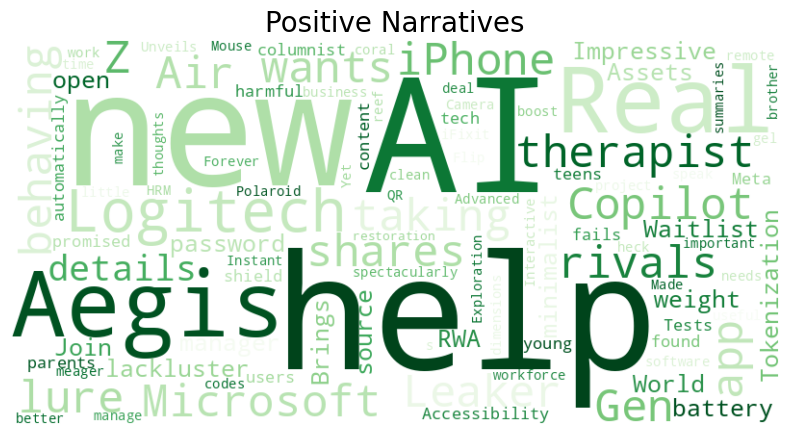

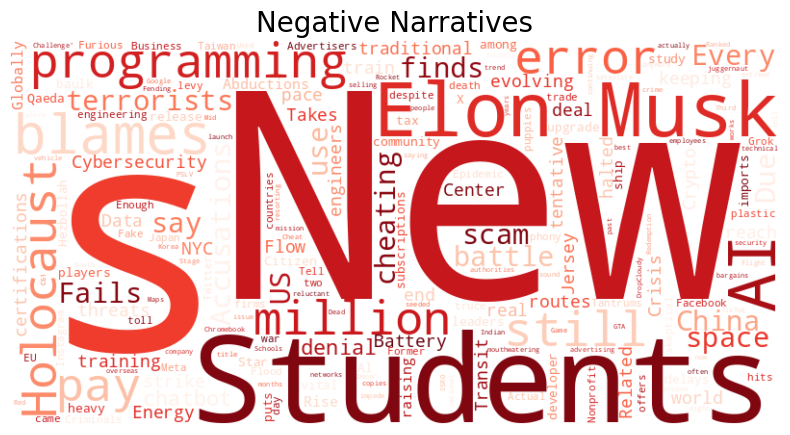

In [4]:
# Re-apply sentiment analysis to the new dataframe before creating word clouds
# We use the analyzer defined in the previous steps
def get_sentiment_label(text):
    score = analyzer.polarity_scores(text)['compound']
    return 'Positive' if score >= 0.05 else ('Negative' if score <= -0.05 else 'Neutral')

df['label'] = df['title'].apply(get_sentiment_label)

# Create two big strings of text based on sentiment labels
positive_text = " ".join(df[df['label'] == 'Positive']['title'])
negative_text = " ".join(df[df['label'] == 'Negative']['title'])

# Function to plot the cloud
def plot_cloud(text, title, color):
    if not text.strip():
        print(f"No text found for {title}")
        return

    # Add custom stopwords common in Reddit research
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update(["reddit", "post", "comment", "subreddit", "user"])

    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   colormap=color,
                   stopwords=custom_stopwords).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Run the clouds
plot_cloud(positive_text, "Positive Narratives", "Greens")
plot_cloud(negative_text, "Negative Narratives", "Reds")

Toxicity Cascade (over time)

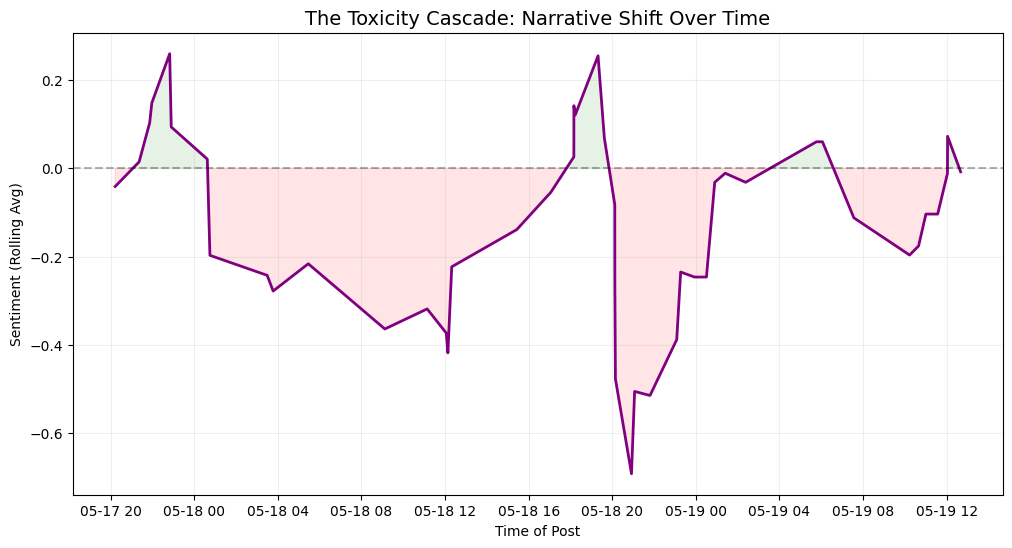

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Ensure your data is sorted by time (earliest to latest)
# Now that 'created_utc' is available, we can create the timestamp
df['timestamp'] = pd.to_datetime(df['created_utc'], unit='s')
df = df.sort_values('timestamp')

# 2. Calculate a Rolling Average
df['rolling_sentiment'] = df['sentiment_score'].rolling(window=5).mean()

# 3. Plot the Cascade
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['rolling_sentiment'], color='purple', linewidth=2, label='Sentiment Trend')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)

# Formatting
plt.title('The Toxicity Cascade: Narrative Shift Over Time', fontsize=14)
plt.xlabel('Time of Post')
plt.ylabel('Sentiment (Rolling Avg)')
plt.grid(True, alpha=0.2)

# Handle potential NaN values in rolling average for the fill_between
mask = df['rolling_sentiment'].notna()
plt.fill_between(df['timestamp'][mask], df['rolling_sentiment'][mask], 0,
                 where=(df['rolling_sentiment'][mask] >= 0), color='green', alpha=0.1, interpolate=True)
plt.fill_between(df['timestamp'][mask], df['rolling_sentiment'][mask], 0,
                 where=(df['rolling_sentiment'][mask] < 0), color='red', alpha=0.1, interpolate=True)

plt.show()

Influence Mapping (Network Analysis)

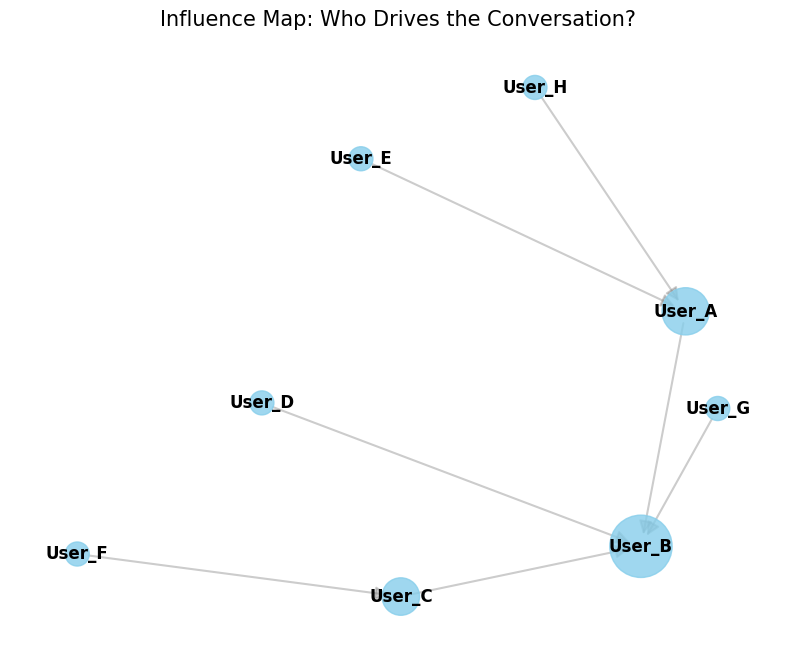

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create a Directed Graph
net = nx.DiGraph()

# Since our current 'df' contains posts, not comments,
# we'll create a sample interaction list to demonstrate the map.
sample_interactions = [
    {'author': 'User_A', 'parent_author': 'User_B'},
    {'author': 'User_C', 'parent_author': 'User_B'},
    {'author': 'User_D', 'parent_author': 'User_B'},
    {'author': 'User_E', 'parent_author': 'User_A'},
    {'author': 'User_F', 'parent_author': 'User_C'},
    {'author': 'User_G', 'parent_author': 'User_B'},
    {'author': 'User_H', 'parent_author': 'User_A'},
]
interaction_df = pd.DataFrame(sample_interactions)

# 2. Add edges (connections)
for index, row in interaction_df.iterrows():
    net.add_edge(row['author'], row['parent_author'])

# 3. Identify "Influencers" (Centrality)
# In-degree centrality shows who is being replied to the most
centrality = nx.in_degree_centrality(net)

# 4. Draw the Network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(net, k=0.8)

# Draw nodes sized by their influence
node_sizes = [(v + 0.1) * 3000 for v in centrality.values()]
nx.draw_networkx_nodes(net, pos, node_size=node_sizes, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(net, pos, width=1.5, alpha=0.4, edge_color="grey", arrowsize=20)
nx.draw_networkx_labels(net, pos, font_size=12, font_weight='bold')

plt.title("Influence Map: Who Drives the Conversation?", fontsize=15)
plt.axis('off')
plt.show()

In [7]:
import pandas as pd

# Convert the centrality dictionary to a Series for easy sorting
influence_series = pd.Series(centrality).sort_values(ascending=False)

print("Top 5 Influencers (by In-Degree Centrality):")
display(influence_series.head(5))

Top 5 Influencers (by In-Degree Centrality):


,0
User_B,0.571429
User_A,0.285714
User_C,0.142857
User_D,0.000000
User_E,0.000000


Now we will use betweenness centrality to Attempt to discover the bridge redditors in our data set.

The primary Bridge User is: User_A
Gatekeeper Score: 0.0476


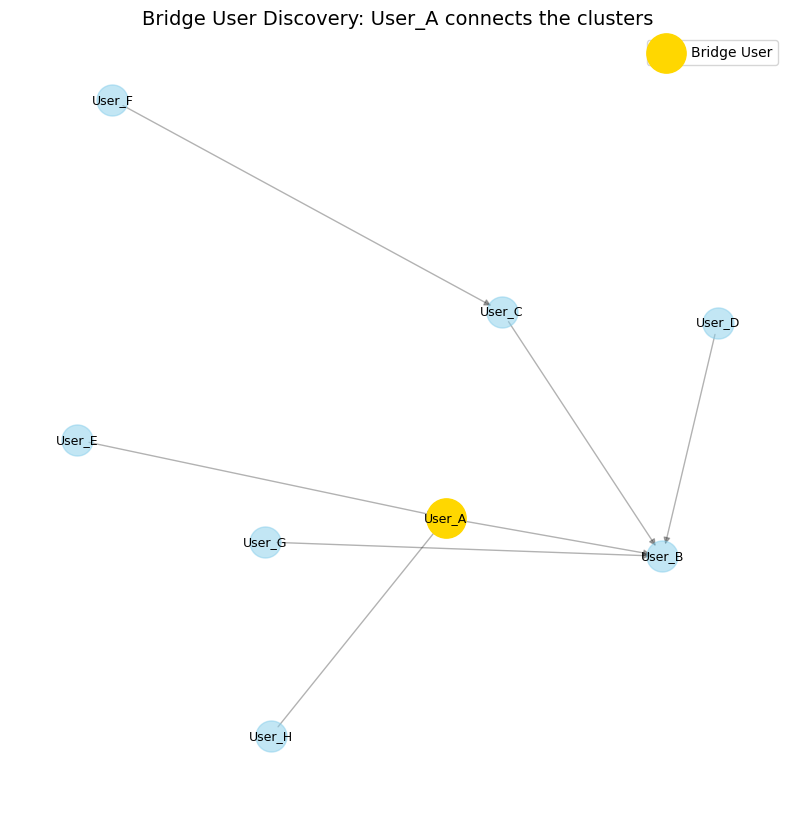

In [8]:
import networkx as nx

# 1. Calculate Betweenness Centrality
# This counts how many "shortest paths" pass through a specific user
betweenness = nx.betweenness_centrality(net)

# 2. Find the top Bridge User
bridge_user = max(betweenness, key=betweenness.get)
bridge_score = betweenness[bridge_user]

print(f"The primary Bridge User is: {bridge_user}")
print(f"Gatekeeper Score: {bridge_score:.4f}")

# 3. Visualize the Bridge
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(net, k=0.6)

# Draw all nodes
nx.draw_networkx_nodes(net, pos, node_size=500, node_color="skyblue", alpha=0.5)

# Highlight the Bridge User in Bright Gold
nx.draw_networkx_nodes(net, pos, nodelist=[bridge_user],
                       node_size=800, node_color="gold", label="Bridge User")

# Draw edges and labels
nx.draw_networkx_edges(net, pos, width=1.0, alpha=0.3)
nx.draw_networkx_labels(net, pos, font_size=9)

plt.title(f"Bridge User Discovery: {bridge_user} connects the clusters", fontsize=14)
plt.legend()
plt.axis('off')
plt.show()